In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install pyspark

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql import SparkSession
from pyspark.sql.functions import abs
import matplotlib.pyplot as plt
from pyspark.sql.window import Window
import warnings
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.style as style
from pyspark.sql.functions import col, avg, date_format
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler

In [ ]:
spark = SparkSession.builder.appName("BDP_Project").getOrCreate()

In [ ]:
data = spark.read.csv("/content/drive/MyDrive/Apple_5000.csv", header=True, inferSchema=True)

# **Linear Regression**

In [ ]:
data = data.withColumn("datetime", data.datetime.cast("timestamp"))
assembler = VectorAssembler(inputCols=["upper_band", "middle_band", "lower_band", "open", "high", "low", "volume"], outputCol="features")
data = assembler.transform(data)

(trainingData, testData) = data.randomSplit([0.7, 0.3])

lr = LinearRegression(featuresCol="features", labelCol="close", maxIter=10, regParam=0.3, elasticNetParam=0.8)
model = lr.fit(trainingData)

predictions = model.transform(testData)

evaluator = RegressionEvaluator(labelCol="close", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("RMSE:", rmse)

coefficients = model.coefficients
intercept = model.intercept
print("Coefficients:", coefficients)
print("Intercept:", intercept)

evaluator = RegressionEvaluator(labelCol="close", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(predictions)
print("R-squared:", r2)

accuracy = (r2 * 100)
print("Accuracy:", accuracy, "%")

RMSE: 0.26461829243489693
Coefficients: [0.1405338720791694,0.1268664852289795,0.09765134812590406,0.16509304717091572,0.1699931799279397,0.16915563909136347,0.0]
Intercept: 21.817211005045152
R-squared: 0.9782225626859113
Accuracy: 97.82225626859113 %


In [ ]:
residuals = predictions.select(abs(predictions["close"] - predictions["prediction"]).alias("residual"))

stats = residuals.agg({"residual": "mean"}).collect()
mean = stats[0]["avg(residual)"]
stats = residuals.agg({"residual": "stddev"}).collect()
stddev = stats[0]["stddev(residual)"]

threshold = mean + 3 * stddev

anomalies = predictions.filter(abs(predictions["close"] - predictions["prediction"]) > threshold)

print("Number of anomalies:", anomalies.count())
anomalies.show()

Number of anomalies: 1
+-------------------+----------+-----------+----------+------+---------+------+------+-------+--------------------+-----------------+
|           datetime|upper_band|middle_band|lower_band|  open|     high|   low| close| volume|            features|       prediction|
+-------------------+----------+-----------+----------+------+---------+------+------+-------+--------------------+-----------------+
|2023-04-27 09:30:00| 164.83059|  163.78745| 162.74432|165.19|165.96001|165.19|165.86|1853052|[164.83059,163.78...|165.0794427332285|
+-------------------+----------+-----------+----------+------+---------+------+------+-------+--------------------+-----------------+



<ipython-input-13-77373c88f722>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  style.use('seaborn-whitegrid')
<ipython-input-13-77373c88f722>:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(x, m*x + b, 'r-', label='Best fit line',color="black")


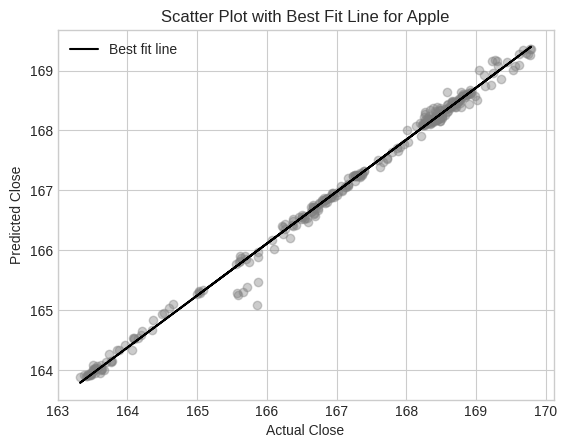

In [ ]:
import matplotlib.style as style
style.use('seaborn-whitegrid')

predictions = model.transform(testData)

predictions = predictions.select("close", "prediction")
predictions = predictions.toPandas()

x = predictions["close"]
y = predictions["prediction"]
m, b = np.polyfit(x, y, 1)

# Plot the predicted and actual values with the best fit line
plt.scatter(predictions["close"], predictions["prediction"],color="grey",alpha=0.4)
plt.plot(x, m*x + b, 'r-', label='Best fit line',color="black")
plt.xlabel("Actual Close")
plt.ylabel("Predicted Close")
plt.title("Scatter Plot with Best Fit Line for Apple")
plt.legend()
plt.show()


# **SMA**

In [ ]:
data = data.withColumn("date", date_format(col("datetime"), "yyyy-MM-dd")) # Convert the datetime column to a date
# Calculate the SMA using a rolling window
windowSpec = Window.partitionBy("date").orderBy("datetime").rowsBetween(-4, 0)
data = data.withColumn("sma", avg("close").over(windowSpec))
groupedData = data.groupBy("date").agg({"sma": "first"}).orderBy("date").show() #data day wise

+----------+----------+
|      date|first(sma)|
+----------+----------+
|2023-04-12|    161.05|
|2023-04-13|     161.7|
|2023-04-14| 164.99001|
|2023-04-17|   164.655|
|2023-04-18|    166.05|
|2023-04-19|  165.9006|
|2023-04-20|    166.47|
|2023-04-21|    165.27|
|2023-04-24| 164.85789|
|2023-04-25| 165.60381|
|2023-04-26|   163.755|
|2023-04-27|    165.86|
|2023-04-28|   168.911|
+----------+----------+



In [ ]:
# Calculate RMSE
evaluator = RegressionEvaluator(labelCol="close", predictionCol="sma", metricName="rmse")
rmse = evaluator.evaluate(data)
print("RMSE:", rmse)

# Calculate R-square
evaluator = RegressionEvaluator(labelCol="close", predictionCol="sma", metricName="r2")
r2 = evaluator.evaluate(data)
print("R-square:", r2)

RMSE: 0.0829884064528301
R-square: 0.9980522350757081


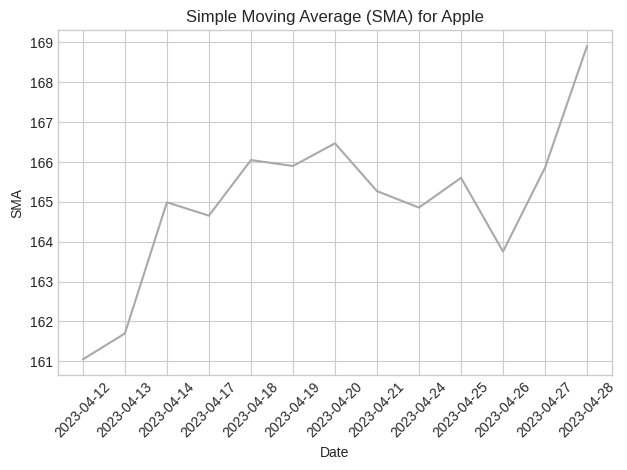

In [ ]:
#Extracting date and SMA values for plotting
groupedData = data.groupBy("date").agg({"sma": "first"}).orderBy("date") #data day wise
date = groupedData.select("date").toPandas()["date"]
sma = groupedData.select("first(sma)").toPandas()["first(sma)"]

# Plot the date and SMA values
fig, ax = plt.subplots()
ax.plot(date, sma,color="darkgrey")
plt.xlabel("Date")
plt.ylabel("SMA")
plt.title("Simple Moving Average (SMA) for Apple")

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# **Random forest**

In [ ]:
apple_data = spark.read.csv("/content/drive/MyDrive/Apple _5000.csv", header=True, inferSchema=True)

# extracting features
data = apple_data.withColumn("datetime", apple_data.datetime.cast("timestamp"))
assembler = VectorAssembler(inputCols=["upper_band", "middle_band", "lower_band", "open", "high", "low", "volume"], outputCol="features")
data = assembler.transform(data)

(train_data, test_data) = data.randomSplit([0.7, 0.3])

# training Random Forest regression model
rf = RandomForestRegressor(featuresCol="features", labelCol="close", numTrees=5, maxDepth=2, minInstancesPerNode=5)
model = rf.fit(train_data)

# making predictions on the testing data
apple_pred = model.transform(test_data)

# evaluating model 
evaluator = RegressionEvaluator(labelCol="close", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(apple_pred)
print("RMSE:", rmse)

evaluator = RegressionEvaluator(labelCol="close", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(apple_pred)
print("R-squared:", r2)

RMSE: 0.549810202376169
R-squared: 0.9164656296713628


# **LSTM**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [ ]:
df = pd.read_csv('/content/Apple.csv')

In [ ]:
# Checking if 'close' column is present in the DataFrame and if not raising an error
if 'close' not in df.columns:
    raise ValueError("Missing 'close' column in the DataFrame.")

data = df.filter(['close'])
dataset = data.values

TrainingDataLength = int(np.ceil(len(dataset) * 0.95))

if dataset.shape[0] == 0:
    raise ValueError("Empty dataset. No data to scale.")

scaler = MinMaxScaler(feature_range=(0,1))
ScaledData = scaler.fit_transform(dataset)

TrainData = ScaledData[0:int(TrainingDataLength), :]
XTrain = []
YTrain = []

for i in range(60, len(TrainData)):
    XTrain.append(TrainData[i-60:i, 0])
    YTrain.append(TrainData[i, 0])
    if i<= 61:
        print(XTrain)
        print(YTrain)
        print()
        
XTrain, YTrain = np.array(XTrain), np.array(YTrain)
XTrain = np.reshape(XTrain, (XTrain.shape[0], XTrain.shape[1], 1))

#building the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (XTrain.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(XTrain, YTrain, batch_size=1, epochs=1)

# Taking a part of training data to improvise the model
TestData = ScaledData[TrainingDataLength - 60: , :]

XTest = []
y_test = dataset[TrainingDataLength:, :]
for i in range(60, len(TestData)):
    XTest.append(TestData[i-60:i, 0])
    

XTest = np.array(XTest)
XTest = np.reshape(XTest, (XTest.shape[0], XTest.shape[1], 1 ))

# predicted price values 
predictions = model.predict(XTest)
predictions = scaler.inverse_transform(predictions)

# RMSE
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

[array([0.9851922 , 0.98020641, 0.97472304, 0.97555965, 0.97522062,
       0.95241562, 0.92636087, 0.92536272, 0.92636985, 0.91588971,
       0.91040534, 0.92187167, 0.90940719, 0.90841103, 0.91539213,
       0.92935135, 0.92187167, 0.92137408, 0.91937977, 0.90916887,
       0.90941816, 0.90544947, 0.90342524, 0.89893803, 0.9019295 ,
       0.89844044, 0.9055093 , 0.90043376, 0.901053  , 0.90338535,
       0.89794087, 0.89844044, 0.90491998, 0.90093234, 0.89694271,
       0.89644513, 0.89544698, 0.90691529, 0.89844044, 0.91339682,
       0.91738445, 0.90990677, 0.90242808, 0.90043376, 0.90044374,
       0.89844942, 0.9019295 , 0.89993618, 0.89345366, 0.89145934,
       0.89046318, 0.89046318, 0.88896744, 0.88597597, 0.88697213,
       0.88846787, 0.88748068, 0.88896744, 0.88747171, 0.88349205])]
[0.873520466669989]

[array([0.9851922 , 0.98020641, 0.97472304, 0.97555965, 0.97522062,
       0.95241562, 0.92636087, 0.92536272, 0.92636985, 0.91588971,
       0.91040534, 0.92187167, 0.9094

0.1949101416788681

In [ ]:
from sklearn.metrics import r2_score

# Calculate R-squared (coefficient of determination)
r2 = r2_score(y_test, predictions)
print("R-squared:", r2)

R-squared: 0.716771010734781


<ipython-input-8-a1e30b13549e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


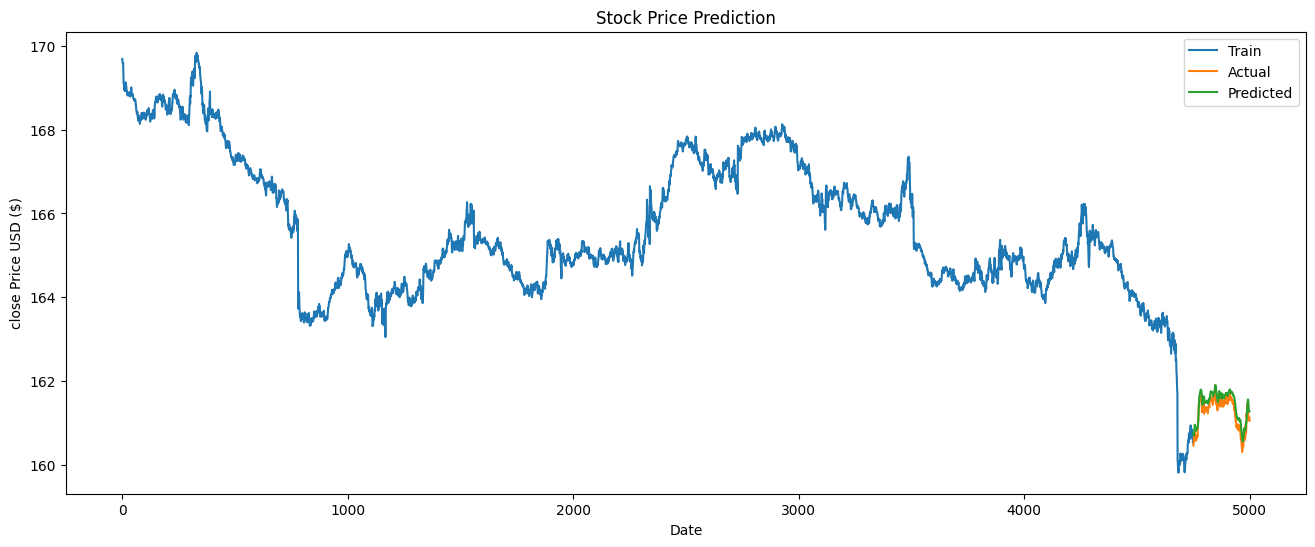

In [ ]:
import matplotlib.pyplot as plt

# Plot the data
train = data[:TrainingDataLength]
valid = data[TrainingDataLength:]
valid['Predictions'] = predictions

plt.figure(figsize=(16, 6))
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('close Price USD ($)')
plt.plot(train['close'], label='Train')
plt.plot(valid['close'], label='Actual')
plt.plot(valid['Predictions'], label='Predicted')
plt.legend(loc='upper right')
plt.show()

# **Decision Tree**

In [ ]:
assembler = VectorAssembler(inputCols=['upper_band', 'middle_band', 'lower_band', 'open', 'high', 'low', 'volume'],
                            outputCol='features')

output = assembler.transform(data)
output.select("features","close").show()

+--------------------+---------+
|            features|    close|
+--------------------+---------+
|[169.72189,169.18...|   169.69|
|[169.64225,169.15...|   169.64|
|[169.56228,169.11...|169.58501|
|[169.48224,169.07...| 169.5934|
|[169.38174,169.03...|   169.59|
|[169.24332,169.00...| 169.3613|
|[169.16503,168.97...|169.10001|
|[169.14887,168.96...|   169.09|
|[169.13458,168.95...| 169.1001|
|[169.11412,168.93...|  168.995|
|[169.10843,168.93...|   168.94|
|[169.10953,168.92...|169.05499|
|[169.09352,168.91...|168.92999|
|[169.0916,168.912...|   168.92|
|[169.09024,168.90...|168.99001|
|[169.08243,168.89...|   169.13|
|[169.03716,168.88...|169.05499|
|[169.00727,168.87...|   169.05|
|[168.9741,168.862...|   169.03|
|[168.93432,168.85...| 168.9276|
+--------------------+---------+
only showing top 20 rows



In [ ]:
model_data = output.select("features","close")
model_data.show()

+--------------------+---------+
|            features|    close|
+--------------------+---------+
|[169.72189,169.18...|   169.69|
|[169.64225,169.15...|   169.64|
|[169.56228,169.11...|169.58501|
|[169.48224,169.07...| 169.5934|
|[169.38174,169.03...|   169.59|
|[169.24332,169.00...| 169.3613|
|[169.16503,168.97...|169.10001|
|[169.14887,168.96...|   169.09|
|[169.13458,168.95...| 169.1001|
|[169.11412,168.93...|  168.995|
|[169.10843,168.93...|   168.94|
|[169.10953,168.92...|169.05499|
|[169.09352,168.91...|168.92999|
|[169.0916,168.912...|   168.92|
|[169.09024,168.90...|168.99001|
|[169.08243,168.89...|   169.13|
|[169.03716,168.88...|169.05499|
|[169.00727,168.87...|   169.05|
|[168.9741,168.862...|   169.03|
|[168.93432,168.85...| 168.9276|
+--------------------+---------+
only showing top 20 rows



In [ ]:
training, testing = model_data.randomSplit([0.7,0.3])

In [ ]:
training.count()

3532

In [ ]:
testing.count()

1468

In [ ]:
from pyspark.ml.regression import DecisionTreeRegressor
dt = DecisionTreeRegressor(labelCol='close').fit(training)
predictions = dt.transform(testing)
predictions.show()

+--------------------+---------+------------------+
|            features|    close|        prediction|
+--------------------+---------+------------------+
|[160.27949,160.14...| 160.0114|160.23286566666667|
|[160.30044,160.12...|   159.98|160.23286566666667|
|[160.30478,160.06...|  160.045|160.23286566666667|
|[160.36956,160.11...|   160.27|160.23286566666667|
|[160.40467,160.11...| 160.2599|160.23286566666667|
|[160.46441,160.12...|160.17999|160.23286566666667|
|[160.52202,160.14...|160.10001|160.61068161290325|
|[160.68188,160.21...|159.85001|160.23286566666667|
|[160.78032,160.30...| 159.8343|160.23286566666667|
|[160.78849,160.53...| 160.7301|160.61068161290325|
|[160.80522,160.37...| 160.0291|160.23286566666667|
|[160.81137,160.63...| 160.6599|160.61068161290325|
|[160.81523,160.65...|   160.53|160.23286566666667|
|[160.81774,160.64...|  160.515|160.61068161290325|
|[160.82535,160.66...|160.46001|160.61068161290325|
|[160.85088,160.65...|160.85091|160.61068161290325|
|[160.85993,

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(labelCol="close",
                                predictionCol="prediction",
                                metricName="rmse")

rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

evaluator = RegressionEvaluator(labelCol="close",
                                predictionCol="prediction",
                                metricName="r2")
r2 = evaluator.evaluate(predictions)
print("R2 on test data = %g" % r2)

Root Mean Squared Error (RMSE) on test data = 0.125538
R2 on test data = 0.995355


# **K Means Clustering**

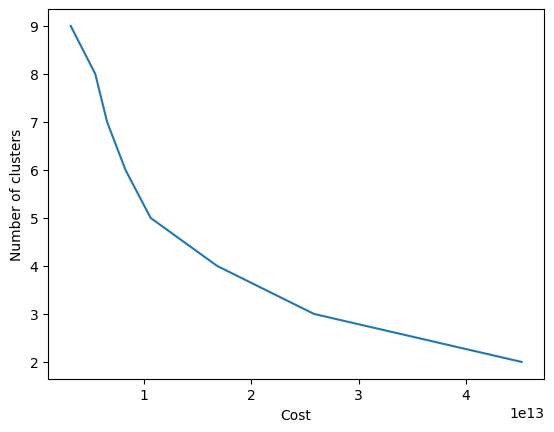

+--------+----------+-----------+----------+------+------+------+------+---------+-------+
|datetime|upper_band|middle_band|lower_band|  open|  high|   low| close|   volume|cluster|
+--------+----------+-----------+----------+------+------+------+------+---------+-------+
|    null|  169.7219|  169.18861| 168.65535|169.64|169.71|169.59|169.69|1188314.0|      3|
|    null|  169.7219|  169.18861| 168.65535|169.64|169.71|169.59|169.69|1188314.0|      4|
|    null|  169.7219|  169.18861| 168.65535|169.64|169.71|169.59|169.69|1188314.0|      4|
|    null|  169.7219|  169.18861| 168.65535|169.64|169.71|169.59|169.69|1188314.0|      4|
|    null|  169.7219|  169.18861| 168.65535|169.64|169.71|169.59|169.69|1188314.0|      4|
|    null|  169.7219|  169.18861| 168.65535|169.64|169.71|169.59|169.69|1188314.0|      4|
|    null|  169.7219|  169.18861| 168.65535|169.64|169.71|169.59|169.69|1188314.0|      0|
|    null|  169.7219|  169.18861| 168.65535|169.64|169.71|169.59|169.69|1188314.0|      0|

In [ ]:
df = spark.read.format("csv").option("header", "true").option("dateFormat", "yyyy-MM-dd HH:mm:ss").load("/content/Apple (1).csv")

df = df.dropna()

df = df.select(*(df[c].cast("float").alias(c) for c in df.columns))

assembler = VectorAssembler(inputCols=["upper_band", "middle_band", "lower_band", "open", "high", "low", "close", "volume"], outputCol="features")
data = assembler.transform(df)

scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(data)
scaled_data = scaler_model.transform(data)

cost = []
for k in range(2, 10):
    kmeans = KMeans().setK(k).setSeed(1)
    model = kmeans.fit(scaled_data)
    cost.append(model.summary.trainingCost)
    
import matplotlib.pyplot as plt
plt.plot(cost, range(2, 10))
plt.ylabel("Number of clusters")
plt.xlabel("Cost")
plt.show()

kmeans = KMeans().setK(5).setSeed(1)
model = kmeans.fit(scaled_data)

predictions = model.transform(scaled_data).select("prediction")

df_with_clusters = df.join(predictions, how='inner').withColumnRenamed('prediction', 'cluster')

df_with_clusters.show()

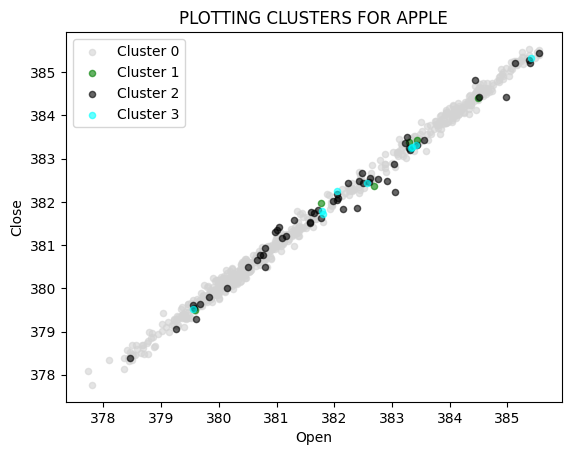

In [ ]:
# Plot the clusters
k=4
colors = ['lightgrey', 'green', 'black', 'cyan']
for i in range(k):
    cluster = pandas_df[pandas_df['cluster'] == i]
    plt.scatter(cluster['open'], cluster['close'], s=20, c=colors[i], label='Cluster '+str(i),alpha=0.6)
plt.legend()
plt.xlabel('Open')
plt.ylabel('Close')
plt.title('PLOTTING CLUSTERS FOR APPLE')
plt.show()